In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.40', '1.0.0')

In [4]:
torch.cuda.set_device(0)

In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-marathi/language-model')

In [6]:
p = path.glob('MarathiWikipediaArticles/*')
files = [x for x in p if x.is_file()]

In [7]:
len(files)

85537

In [8]:
train_files, test_files = train_test_split(files, test_size=0.3)

In [9]:
len(train_files), len(test_files)

(59875, 25662)

In [10]:
train_files[0]

PosixPath('/home/gaurav/PycharmProjects/nlp-for-marathi/language-model/MarathiWikipediaArticles/24822.pkl')

In [11]:
str(train_files[0]).split('/')[-1][:-4]

'24822'

In [12]:
# Preparing dataset for fastai
for file in train_files:
    with open(file, 'rb') as f:
        text = pickle.load(f)
    with open(path/'MarathiDataset'/'train'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
        text_file.write(text)

In [13]:
for file in test_files:
    with open(file, 'rb') as f:
        text = pickle.load(f)
    with open(path/'MarathiDataset'/'valid'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
        text_file.write(text)

In [14]:
class MarathiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/marathi_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [15]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/marathi_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [16]:
# 30,000 is the vocab size that we chose in sentencepiece
marathi_vocab = Vocab(itos)

In [17]:
tokenizer = Tokenizer(tok_func=MarathiTokenizer, lang='mr')

In [18]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [19]:
data_lm = TextLMDataBunch.from_folder(path=path/'MarathiDataset', tokenizer=tokenizer, vocab=marathi_vocab)

In [20]:
data_lm.batch_size

64

In [21]:
data_lm.save()

In [23]:
data_lm.show_batch()

idx,text
0,▁x x bo s ▁घनमीटर ▁हे ▁आकारमान ▁मोजण्या चे ▁एक ▁एकक ▁आहे . ▁१ ▁मी ▁ x ▁१ ▁मी ▁ x ▁१ ▁मी ▁एवढ्या ▁क्षेत्राचे ▁आकारमान ▁१ ▁घनमीटर ▁असते . ▁x x bo s ▁अल्माटी ▁हा ▁मध्य ▁आशियातील ▁कझाकस्तान ▁देशाचा ▁एक ▁प्रांत ▁आहे . ▁अल्माटी ▁ह्याच ▁नावाचे ▁मोठे ▁शहर ▁ह ्य ▁प्रांत ाच्या ▁अंतर्गत ▁असले ▁तरी ▁ते ▁राजकीय ▁दृष्ट्या ▁अल्माटी ▁प्रांत ाचा ▁भाग ▁नसून ▁एक ▁स्वायत्त ▁शहर ▁आहे . ▁गुणक
1,. ▁तसेच ▁टायगर ▁कॅपिटल ▁ऑफ ▁इंडिया ▁पण ▁सं भो तात . ▁नागपुर ास ▁संत ्रा नगरी ▁असे ही ▁संबोधतात ▁कारण ▁शहरातील ▁संत ्री ▁प्रसिद्ध ▁आहेत . ▁मोठ्या ▁प्रमाणावर ▁संत्र्या चे ▁पिके ▁येथे ▁होतात . ▁संत्र्या च्या ▁बागा ▁मोठ्या ▁प्रमाणावर ▁आढळून ▁येतात . ▁त्यामुळे ▁संत्र्या ची ▁मोठी ▁बाजारपेठ ▁येथे ▁आहे . ▁ नुकताच ▁2002 ▁मध्ये ▁शहराचा ▁३०० वा ▁वर्धा पन दिन ▁साजरा ▁करण्यात ▁आला . ▁नजिकच्या ▁आ थि र्क ▁गुंतवणूक ीमुळे
2,▁या ▁विभागात ▁समावेश ▁होतो . ▁कोत े ▁पाटील ांच्या ▁नावावरून ▁कोथरूड ▁असे ▁नाव ▁पडले ▁असा ▁एक ▁प्र वाद ▁आहे . . ▁पुरेसे ▁ऐतिहासिक ▁पुरावे ▁उपलब्ध ▁नसले ▁तरीही ▁थोरले ▁बाजीराव ांच्या ▁काळात ▁त्यांच्या ▁द्वितीय ▁भार ्या ▁मस्तानी ▁यांचा ▁महाल ही ▁कोथरूड ▁बाग ▁परिसरात ▁असावा ▁असे ▁मानले ▁जात ▁असे . ▁कोथरूड ▁गावठाण ▁येथे ▁नाना ▁फडणवीस ▁यांची ▁पेरू ची ▁बाग ▁होती . त्यांच्या ▁पश्चात ▁ब्रिटिश ▁काळातील ▁कलेक्टर ▁मॉर्गन ▁यांनी ▁काढलेल्या ▁लिलाव ात ▁हि
3,"ur se . ▁it ▁cr os s es ▁ ri ver ava ri ▁near ▁k op ar ga on , ▁the ava ra ▁near ▁k ol har , ▁the la ▁near hu ri ▁and ▁the ▁b hi ma ▁near ▁the ▁ district ▁b order ▁where ▁there ▁are ▁ br id ge s . ▁it ▁cr os s es ▁a ▁major ▁na ll ah"
4,"▁my ▁place . ▁he ▁who ▁so ▁ ack n ow led ge s ▁it ▁will ▁ o b ta in ▁his ▁re ward . ▁the ▁will ▁ res cu e ▁him . ▁k n ow ▁this ▁as ▁the ▁truth "" . ▁g obind ▁thus ▁pass ed ▁on ▁the ▁success ion ▁with ▁du e ▁ceremony ▁to ▁the ly o k , ▁the"


In [24]:
len(data_lm.vocab.itos)

30000

In [25]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [26]:
gc.collect()

0

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


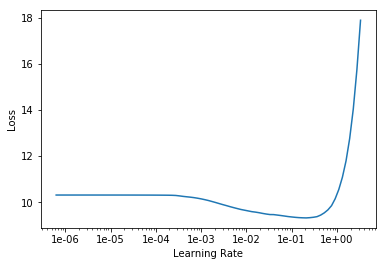

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.510442,4.438874,0.315410


In [30]:
learn.save('first', with_opt=True)

In [31]:
learn.load('first', with_opt=True);

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.382417,4.451831,0.310669
2,4.379301,4.400976,0.312358
3,4.051602,4.094686,0.342677
4,3.679856,3.718292,0.392597
5,3.327582,3.598108,0.410449


In [34]:
learn.save('second_gu_lm', with_opt=True)

In [35]:
learn.load('second_gu_lm', with_opt=True);

In [36]:
learn.fit_one_cycle(40, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.421837,3.589710,0.411864
2,3.283107,3.579655,0.413513
3,3.311975,3.565250,0.415898
4,3.144865,3.546464,0.419021
5,3.390587,3.524449,0.422398
6,3.243941,3.498798,0.426690
7,3.236669,3.473009,0.431035
8,3.384805,3.440805,0.436178
9,3.314674,3.411994,0.441093
10,3.268296,3.384046,0.445948


In [37]:
learn.save('third_mr_lm', with_opt=True)

In [38]:
learn.load('third_mr_lm', with_opt=True);

In [39]:
learn.fit_one_cycle(20, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.439824,2.914547,0.528714
2,2.477008,2.914123,0.528784
3,2.462474,2.913254,0.528912
4,2.525224,2.912550,0.529204
5,2.542871,2.911019,0.529602
6,2.473117,2.909723,0.529762
7,2.483403,2.906476,0.530446
8,2.543327,2.904446,0.530686
9,2.528812,2.902434,0.531177
10,2.589246,2.900583,0.531355


In [46]:
learn.save('fourth_mr_lm', with_opt=True)

In [40]:
TEXT = "तसेच टायगर कॅपिटल"
N_WORDS = 40
N_SENTENCES = 2

In [44]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

तसेच टायगर कॅपिटल मध्ये ▁लोकवस्ती ▁होती . त्यात ▁केवळ ▁संरक्षण ▁आणि ▁नेतृत्व ▁सर्वदूर ▁पसरले ▁हॉटेल ची ▁सुरुवात ▁करण्यात ▁आली ▁आणि ▁विविध ▁प्रकारचे ▁संशोधन ▁खर्च ▁वाढले . ▁6 ▁सप्टेंबर ▁2002 ▁रोजी ▁ ▁भारत ▁आणि ▁इंग्लंड ▁जवळील ▁व्यापार ▁अत्यंत ▁गंभीर ▁होता ▁परंतु ▁विनिमय ▁प्रकल्प ावर
तसेच टायगर कॅपिटल ▁ऑफ ▁इंडिया , स्ट ॉर ण्ड ि रिआ ▁व ▁शे न ॅप ् रिफ , ▁इंडियन ▁राय , ▁दक्षिण म ्या ळ , , ▁ ▁वा ▁लोकप्रिय ▁फ़ िंग ▁तसेच ▁शिक्षण ▁व्यवसाय , आणि ▁वे ंग रूम , आणि ▁


In [45]:
np.exp(2.89)

17.99330960155032